# 激活函数

In [1]:
import torch
from d2l import torch as d2l

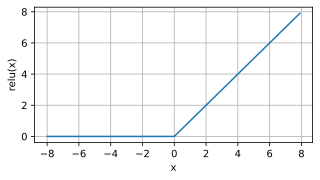

In [2]:
x = torch.arange(-8., 8., 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

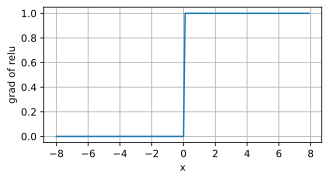

In [3]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

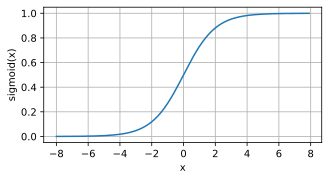

In [4]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

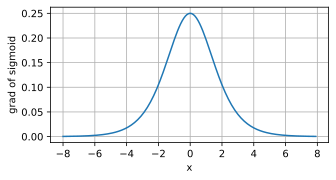

In [5]:
x.grad.data.zero_()
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

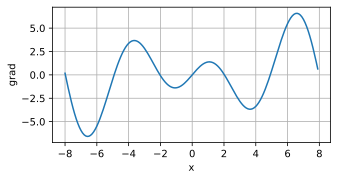

In [12]:
# 求单个函数的导数
def f(x):
    return x * torch.sin(x)


x = torch.arange(-8., 8., 0.1, requires_grad=True)
y = f(x)
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad', figsize=(5, 2.5))

# 4.2 多层感知机的构建

In [11]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [20]:
from torch import nn

num_inputs, num_outputs, num_hiddens = 784, 10, 256
W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

In [29]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [30]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(torch.matmul(X, W1) + b1)
    return torch.matmul(H, W2) + b2

In [23]:
loss = nn.CrossEntropyLoss(reduction='none')

In [5]:
def current_num(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(dim=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())


class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(current_num(net(X), y), y.numel())
    return metric[0] / metric[1]


def train_epoch(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])
        metric.add(l.sum(), current_num(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]


def train(net, train_iter, test_iter, loss, num_epochs, updater):
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        print(
            f'epoch {epoch + 1}: loss {train_metrics[0]:.3f}, train acc {train_metrics[1]:.3f}, test acc {test_acc:.3f}')
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [32]:
num_epochs, lr = 5, 0.1
updater = torch.optim.SGD(params, lr=lr)
train(net, train_iter, test_iter, loss, num_epochs, updater)

epoch 1: loss 0.437, train acc 0.846, test acc 0.825
epoch 2: loss 0.422, train acc 0.852, test acc 0.821
epoch 3: loss 0.407, train acc 0.856, test acc 0.843
epoch 4: loss 0.395, train acc 0.861, test acc 0.852
epoch 5: loss 0.385, train acc 0.864, test acc 0.847


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)


def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)


net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

In [3]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

In [7]:
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
train(net, train_iter, test_iter, loss, num_epochs, trainer)

epoch 1: loss 1.049, train acc 0.629, test acc 0.759
epoch 2: loss 0.602, train acc 0.788, test acc 0.792
epoch 3: loss 0.519, train acc 0.819, test acc 0.804
epoch 4: loss 0.477, train acc 0.833, test acc 0.819
epoch 5: loss 0.455, train acc 0.840, test acc 0.828
epoch 6: loss 0.436, train acc 0.846, test acc 0.824
epoch 7: loss 0.415, train acc 0.854, test acc 0.827
epoch 8: loss 0.405, train acc 0.857, test acc 0.830
epoch 9: loss 0.393, train acc 0.861, test acc 0.812
epoch 10: loss 0.384, train acc 0.864, test acc 0.845


In [9]:
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 256),
    nn.ReLU(),
    nn.Linear(256, 100)
)

params = []
for x in net:
    if type(x) == nn.Linear:
        params.append({'params':x.weight, 'weight_decay': 1})
        params.append({'params':x.bias})

params

[{'params': Parameter containing:
  tensor([[-0.0278,  0.0161, -0.0022,  ..., -0.0131,  0.0042,  0.0177],
          [ 0.0108,  0.0107,  0.0025,  ...,  0.0115,  0.0078, -0.0319],
          [-0.0039, -0.0282, -0.0126,  ...,  0.0263, -0.0265,  0.0066],
          ...,
          [-0.0351,  0.0049, -0.0105,  ..., -0.0234, -0.0029, -0.0318],
          [-0.0226,  0.0352,  0.0191,  ..., -0.0169, -0.0129,  0.0143],
          [-0.0081,  0.0040,  0.0147,  ..., -0.0003, -0.0152,  0.0235]],
         requires_grad=True),
  'weight_decay': 1},
 {'params': Parameter containing:
  tensor([-0.0182,  0.0141,  0.0022, -0.0268, -0.0080,  0.0065, -0.0044,  0.0338,
           0.0171,  0.0207,  0.0163,  0.0202,  0.0004,  0.0064,  0.0169,  0.0232,
          -0.0066, -0.0154, -0.0195,  0.0331, -0.0244, -0.0189,  0.0056,  0.0102,
          -0.0010,  0.0042,  0.0028, -0.0063, -0.0051,  0.0219,  0.0197, -0.0007,
           0.0149, -0.0044,  0.0152, -0.0067, -0.0184, -0.0252,  0.0087, -0.0226,
           0.0349, -0.